In [1]:
import random
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from scipy import stats
from truesight.preprocessing import Preprocessor
from truesight.core import TrueSight
from truesight.metrics import Evaluator, smape, mape, mse, rmse, mae

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
season_length = 30
forecast_horizon = 30

In [12]:
df = pd.read_csv('datasets\\Stock Market\\stock_market.csv')
df['ds'] = pd.to_datetime(df['ds'])
df = df[df['ds'] >= '2022-01-01']
df = df[['unique_id', 'ds', 'y']]
df.reset_index(drop = True, inplace = True)
df.fillna(0, inplace = True)
df = pd.merge(df, df.groupby('unique_id')[['y']].count().reset_index().rename(columns = {'y': 'count'}), how='left', on='unique_id')
df = df[df['count'] => 238]
df = df[['unique_id', 'ds', 'y']]

In [25]:
if False:
    from statsforecast.models import SeasonalNaive, AutoETS, AutoARIMA
    from sklearn.linear_model import LinearRegression
    from truesight.utils import ModelWrapper

    models = [
        ModelWrapper(LinearRegression, horizon=forecast_horizon, season_length=season_length, alias="LinearRegression"),
        ModelWrapper(AutoETS, horizon=forecast_horizon, season_length=season_length),
        ModelWrapper(AutoARIMA, horizon=forecast_horizon, season_length=season_length),
    ]

    preprocessor = Preprocessor(df)
    X_train, Y_train, ids_train, X_val, Y_val, ids_val, models = preprocessor.make_dataset(
        forecast_horizon = forecast_horizon, 
        season_length = season_length,
        date_freq = "D", 
        models = models, 
        fallback_model = ModelWrapper(SeasonalNaive, horizon=forecast_horizon, season_length=season_length),
        verbose = True
        )
    pickle.dump((X_train, Y_train, ids_train, X_val, Y_val, ids_val, models), open('datasets\\Stock Market\\stock_market.pkl', 'wb'))
else:
    X_train, Y_train, ids_train, X_val, Y_val, ids_val, models = pickle.load(open('datasets\\Stock Market\\stock_market.pkl', 'rb'))

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True, monitor = "val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 4, verbose = False),
]

if True:
    models_nocov = models[-1:]
    X_train_nocov = X_train[-1:]
    X_val_nocov = X_val[-1:]

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    ts_nocov = TrueSight(models_nocov, forecast_horizon, filter_size = 64, context_size = 256, hidden_size = 1024, dropout_rate = 0.1)
    ts_nocov.compile(optimizer=optimizer, loss='mse')

    ts_nocov.fit(
        x = X_train_nocov, y = Y_train,
        validation_data = [X_val_nocov, Y_val],
        batch_size = 32,
        epochs = 1000,
        verbose = True,
        callbacks = callbacks,
    )
    ts_nocov.plot_training_history()
    ts_nocov.save_weights('nocov.h5')

    models_wcov = models.copy()
    X_train_wcov = X_train.copy()
    X_val_wcov = X_val.copy()

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    ts_wcov= TrueSight(models_wcov, forecast_horizon, filter_size = 64, context_size = 256, hidden_size = 1024, dropout_rate = 0.1)
    ts_wcov.compile(optimizer=optimizer, loss='mse')

    ts_wcov.fit(
        x = X_train_wcov, y = Y_train,
        validation_data = [X_val_wcov, Y_val],
        batch_size = 32,
        epochs = 1000,
        verbose = True,
        callbacks = callbacks,
    )
    ts_wcov.plot_training_history()
    ts_wcov.save_weights('ts_wcov.h5')

    yhat_nocov = ts_nocov.predict(X_val_nocov, n_repeats = 100, n_quantiles = 15, verbose = False)
    yhat_wcov = ts_wcov.predict(X_val_wcov, n_repeats = 100, n_quantiles = 15, verbose = False)
else:
    yhat_nocov = np.load('/content/drive/MyDrive/Forecast-M5/yhat_nocov.npy')
    yhat_wcov = np.load('/content/drive/MyDrive/Forecast-M5/yhat_wcov.npy')

In [27]:
evaluator_wcov = Evaluator(X_val, Y_val, yhat_wcov, ids_val)
evaluator_wcov.evaluate_prediction(evaluators = [smape, mape, mse, rmse, mae], return_mean = True)

smape    2.876692e-01
mape     5.184528e+01
mse      3.518432e+08
rmse     7.748127e+02
mae      7.740220e+02
dtype: float64

In [28]:
evaluator_nocov = Evaluator(X_val, Y_val, yhat_nocov, ids_val)
evaluator_nocov.evaluate_prediction(evaluators = [smape, mape, mse, rmse, mae], return_mean = True)

smape    4.284977e-01
mape     2.010397e+02
mse      3.499765e+08
rmse     7.807677e+02
mae      7.768452e+02
dtype: float64

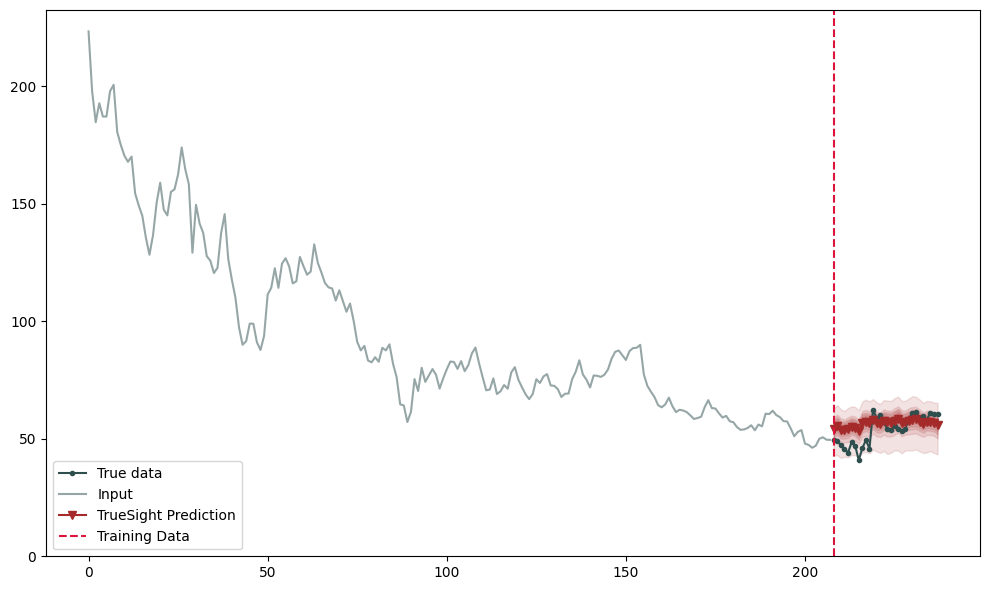

In [49]:
evaluator_wcov.plot_exemple()

In [50]:
group_a = smape(Y_val, yhat_wcov.mean(axis=0))
group_b = smape(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -4.584964088388555
P-Value: 5.0225481216249605e-06


In [54]:
group_a = mse(Y_val, yhat_wcov.mean(axis=0))
group_b = mse(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 0.003761528143838395
P-Value: 0.9969993754971269


In [55]:
group_a = mae(Y_val, yhat_wcov.mean(axis=0))
group_b = mae(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_ind(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -0.002596503310915997
P-Value: 0.9979287298179864
